In [3]:
from selenium.webdriver import Chrome
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pymongo
from selenium.common.exceptions import NoSuchElementException
from cost_of_living import *
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline
from hidden import debt

## Use this to download a DataFrame to csv, pickle a DF, and unpickle a DF

In [2]:
#avg_salaries_df.to_csv("avg_salaries.csv", index=False)

##  Pickle DF ##
#citydf.to_pickle('citydf')
##  Unpickle DF ##
# df = pd.read_pickle(file_name)

##  Save DF to excel ##
#writer = pd.ExcelWriter('citydf.xlsx')
#citydf.to_excel(writer,'citydf')
#writer.save()

## Declare cities of interest

In [7]:
cities = ['Palo-Alto', 'San-Jose', 'Portland', 'Austin', 'Denver', 'San-Diego', 'Washington', 'Boston', 
                 'San-Francisco', 'Seattle', 'Atlanta', 'Los-Angeles', 'Chicago', 'New-York', 'Mountain-View',
                 'Santa-Monica', 'Cambridge', 'Salt-Lake-City', 'Raleigh', 'Nashville', 'Sunnyvale', 'Boulder',
                 'Irvine', 'Philadelphia', 'Dallas', 'Bellevue', 
                 'Charlotte', 'Plano', 'Richmond']

## Scrape Cost-Of-Living data and turn into DataFrame

In [14]:
city_data = list(scrape_cities(cities))

In [15]:
citydf = pd.DataFrame(city_data)

## Remove characters from price columns that will cause problems later

In [16]:
citydf['price'] = citydf['price'].apply(lambda x : x.replace(',', '').replace('£', ''))

## Create a monthy constants object that can be used to calculate cost-of-living expenditures that are specific for each city

In [8]:
monthly_constants = {
'Cinema, International Release, 1 Seat' : 2,
'Fitness Club, Monthly Fee for 1 Adult' : 2,
'Basic (Electricity, Heating, Cooling, Water, Garbage) for 915 sq ft Apartment' : 1,
'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)' : 1,
'Gasoline (1 gallon)' : 15,
'Imported Beer (11.2 oz small bottle)' : 10,
'Bottle of Wine (Mid-Range)' : 2,
'Cappuccino (regular)'  : 30,
'Meal, Inexpensive Restaurant' : 8,
'1 Pair of Jeans (Levis 501 Or Similar)' : 1
}

## Write funcions to calculate the specific cost-of-living for 4 different prespecified living situations

In [9]:
def cost_per_city_1B_Center(citydf, cities):
    for city in cities:
        total = 0
        for item, price in monthly_constants.items():
            price = float(citydf[(citydf['city']==city) & (citydf['item']==item)].values[0][3]) * price
            total += price
        total += 600 # for groceries & transportation
        total += (float(citydf[(citydf['city']==city) & 
                               (citydf['item']=='Apartment (1 bedroom) in City Centre')].values[0][3]))
        result = {
        'city' : city,
        '1_Bed_Center_Total' : total
                  }
        yield result

In [10]:
def cost_per_city_3B_Center(citydf, cities):
    for city in cities:
        total = 0
        for item, price in monthly_constants.items():
            price = float(citydf[(citydf['city']==city) & (citydf['item']==item)].values[0][3]) * price
            total += price
        total += 600 # for groceries & transportation
        total += round((float(citydf[(citydf['city']==city) & 
                               (citydf['item']=='Apartment (3 bedrooms) in City Centre')].values[0][3]) / 3),2)
        result = {
        'city' : city,
        '3_Bed_Center_Total' : total
                  }
        yield result

In [11]:
def cost_per_city_3B_Outside(citydf, cities):
    for city in cities:
        total = 0
        for item, price in monthly_constants.items():
            price = float(citydf[(citydf['city']==city) & (citydf['item']==item)].values[0][3]) * price
            total += price
        total += 600 # for groceries & transportation
        total += round(((float(citydf[(citydf['city']==city) & 
                               (citydf['item']=='Apartment (3 bedrooms) Outside of Centre')].values[0][3])) / 3),2)
        result = {
        'city' : city,
        '3_Bed_Outside_Total' : total
                  }
        yield result

In [12]:
def cost_per_city_1B_Outside(citydf, cities):
    for city in cities:
        total = 0
        for item, price in monthly_constants.items():
            price = float(citydf[(citydf['city']==city) & (citydf['item']==item)].values[0][3]) * price
            total += price
        total += 600 # for groceries & transportation
        total += (float(citydf[(citydf['city']==city) & 
                               (citydf['item']=='Apartment (1 bedroom) Outside of Centre')].values[0][3]))
        result = {
        'city' : city,
        '1_Bed_Outside_Total' : total
                  }
        yield result

## Create a dataframe of all 4 living situations - for each city

In [22]:
B1_center = list(cost_per_city_1B_Center(citydf, cities))
B3_center = list(cost_per_city_3B_Center(citydf, cities))
B1_Outside = list(cost_per_city_1B_Outside(citydf, cities))
B3_Outside = list(cost_per_city_3B_Outside(citydf, cities))
B1_center = pd.DataFrame(B1_center)
B3_center = pd.DataFrame(B3_center)
B1_Outside = pd.DataFrame(B1_Outside)
B3_Outside = pd.DataFrame(B3_Outside)

In [23]:
B1_center.set_index('city', inplace=True)
B3_center.set_index('city', inplace=True)
B1_Outside.set_index('city', inplace=True)
B3_Outside.set_index('city', inplace=True)

In [24]:
dfs = [B1_center, B3_center, B1_Outside, B3_Outside]
city_matrix = pd.concat(dfs, axis=1)
city_matrix['city'] = city_matrix.index

## Make a slim DataFrame, which includes a couple less cities, and, therefore, is a little more focused for our purposes

In [25]:
slim_city = city_matrix.loc[city_matrix['city'].isin(['Palo-Alto', 'San_Jose', 'Austin', 'Denver', 'San-Diego', 'Washington',
                                          'Boston', 'San-Francisco', 'Seattle', 'Los_Angeles', 'Chicago', 'New-York',
                                         'Mountain-View', 'Cambridge', 'Philadelphia', 'Dallas', 'Richmond'])]
slim_city.drop(columns='city')

,1_Bed_Center_Total,3_Bed_Center_Total,1_Bed_Outside_Total,3_Bed_Outside_Total
city,,,,
Palo-Alto,4387.78,3127.85,4094.51,2872.29
Austin,2969.98,2289.77,2399.66,1943.74
Denver,2910.66,2213.23,2577.82,1985.90
San-Diego,3210.41,2406.10,2804.00,2184.68
Washington,3517.19,2701.16,3063.85,2313.91
Boston,3821.53,2853.37,3136.48,2316.50
San-Francisco,4815.12,3350.49,4076.46,2863.90
Seattle,3374.11,2609.85,2867.34,2217.15
Chicago,3078.89,2405.30,2463.50,1993.23


# Scrape Salaries

## Write function to find salary range

In [26]:
salaries_dct = {
    'palo-alto' : 'https://www.glassdoor.com/Salaries/san-jose-data-scientist-salary-SRCH_IL.0,8_IM761_KO9,23.htm',
    'san-jose' : 'https://www.glassdoor.com/Salaries/san-jose-data-scientist-salary-SRCH_IL.0,8_IM761_KO9,23.htm',
    'portland' : 'https://www.glassdoor.com/Salaries/portland-data-scientist-salary-SRCH_IL.0,8_IM700_KO9,23.htm',
    'austin' : 'https://www.glassdoor.com/Salaries/austin-data-scientist-salary-SRCH_IL.0,6_IM60_KO7,21.htm',
    'denver' : 'https://www.glassdoor.com/Salaries/denver-data-scientist-salary-SRCH_IL.0,6_IM234_KO7,21.htm',
    'san-diego' : 'https://www.glassdoor.com/Salaries/san-diego-data-scientist-salary-SRCH_IL.0,9_IM758_KO10,24.htm',
    'washington' : 'https://www.glassdoor.com/Salaries/washington-dc-data-scientist-salary-SRCH_IL.0,13_IM911_KO14,28.htm',
    'boston' : 'https://www.glassdoor.com/Salaries/boston-data-scientist-salary-SRCH_IL.0,6_IM109_KO7,21.htm',
    'san-francisco' : 'https://www.glassdoor.com/Salaries/san-francisco-data-scientist-salary-SRCH_IL.0,13_IM759_KO14,28.htm',
    'seattle' : 'https://www.glassdoor.com/Salaries/seattle-data-scientist-salary-SRCH_IL.0,7_IM781_KO8,22.htm',
    'atlanta' : 'https://www.glassdoor.com/Salaries/atlanta-data-scientist-salary-SRCH_IL.0,7_IM52_KO8,22.htm',
    'los-angeles' : 'https://www.glassdoor.com/Salaries/los-angeles-data-scientist-salary-SRCH_IL.0,11_IM508_KO12,26.htm',
    'chicago' : 'https://www.glassdoor.com/Salaries/chicago-data-scientist-salary-SRCH_IL.0,7_IM167_KO8,22.htm',
    'new-york' : 'https://www.glassdoor.com/Salaries/new-york-city-data-scientist-salary-SRCH_IL.0,13_IM615_KO14,28.htm',
    'mountain-view' : 'https://www.glassdoor.com/Salaries/san-jose-data-scientist-salary-SRCH_IL.0,8_IM761_KO9,23.htm',
    'santa-monica' : 'https://www.glassdoor.com/Salaries/los-angeles-data-scientist-salary-SRCH_IL.0,11_IM508_KO12,26.htm',
    'cambridge' : 'https://www.glassdoor.com/Salaries/boston-data-scientist-salary-SRCH_IL.0,6_IM109_KO7,21.htm',
    'salt-lake-city' : 'https://www.glassdoor.com/Salaries/salt-lake-city-data-scientist-salary-SRCH_IL.0,14_IM755_KO15,29.htm',
    'raleigh' : 'https://www.glassdoor.com/Salaries/raleigh-data-scientist-salary-SRCH_IL.0,7_IM714_KO8,22.htm',
    'nashville' : 'https://www.glassdoor.com/Salaries/nashville-data-scientist-salary-SRCH_IL.0,9_IM604_KO10,24.htm',
    'sunnyvale' : 'https://www.glassdoor.com/Salaries/san-jose-data-scientist-salary-SRCH_IL.0,8_IM761_KO9,23.htm',
    'boulder' : 'https://www.glassdoor.com/Salaries/boulder-data-scientist-salary-SRCH_IL.0,7_IM110_KO8,22.htm',
    'irvine' : 'https://www.glassdoor.com/Salaries/los-angeles-data-scientist-salary-SRCH_IL.0,11_IM508_KO12,26.htm',
    'philadelphia' : 'https://www.glassdoor.com/Salaries/philadelphia-data-scientist-salary-SRCH_IL.0,12_IM676_KO13,27.htm',
    'dallas' : 'https://www.glassdoor.com/Salaries/dallas-data-scientist-salary-SRCH_IL.0,6_IM218_KO7,21.htm',
    'bellevue' : 'https://www.glassdoor.com/Salaries/seattle-data-scientist-salary-SRCH_IL.0,7_IM781_KO8,22.htm',
    'charlotte' : 'https://www.glassdoor.com/Salaries/charlotte-data-scientist-salary-SRCH_IL.0,9_IM162_KO10,24.htm',
    'Plano' : 'https://www.glassdoor.com/Salaries/dallas-data-scientist-salary-SRCH_IL.0,6_IM218_KO7,21.htm',
    'Richmond' : 'https://www.glassdoor.com/Salaries/richmond-data-scientist-salary-SRCH_IL.0,8_IM724_KO9,23.htm',    
}


In [13]:
def get_glassdoor_salaries(salaries_dct):
    """ Return a dict of city, avg_salary, and, if available, min/max salaries per city."""
    for city, url in salaries_dct.items():
        browser = Chrome()
        browser.get(url)
        sel_title = 'span.OccMedianBasePayStyle__payNumber' # This is for average salaries 
        sel_title2 = 'div.HistogramStyle__labelWrapper' # This is for the low range of salaries
        avg_salary = browser.find_element_by_css_selector(sel_title).text.strip().strip('$').replace(',','')
        min_salary = browser.find_element_by_css_selector(sel_title2).text.replace('K', '000').strip('\nLow').strip('$')
        result = {'city': city,
                  'avg_salary': avg_salary,
                  'min_salary': min_salary}
        yield result
        browser.quit()

## Make a DataFrame of salary information for each city

In [28]:
glassdoor_salaries = list(get_glassdoor_salaries(salaries_dct))

In [29]:
glassdoor_salaries = pd.DataFrame(glassdoor_salaries)

In [30]:
glassdoor_columns=["city", "min_salary", "avg_salary"]
glassdoor_salaries = glassdoor_salaries.reindex(columns=glassdoor_columns)

## Change index to match the same style (capitalization, hyphen instead of space) as other DataFrames so that we can seamlessly concatenate them

In [31]:
glassdoor_index = ['Palo-Alto', 'San-Jose', 'Portland', 'Austin', 'Denver', 'San-Diego',
       'Washington', 'Boston', 'San-Francisco', 'Seattle', 'Atlanta',
       'Los-Angeles', 'Chicago', 'New-York', 'Mountain-View', 'Santa-Monica',
       'Cambridge', 'Salt-Lake-City', 'Raleigh', 'Nashville', 'Sunnyvale',
       'Boulder', 'Irvine', 'Philadelphia', 'Dallas', 'Bellevue', 'Charlotte',
       'Plano', 'Richmond']
glassdoor_salaries.index = glassdoor_index

## Graph min Data Science salary by city - notice that y-axis is inverted

<BarContainer object of 29 artists>

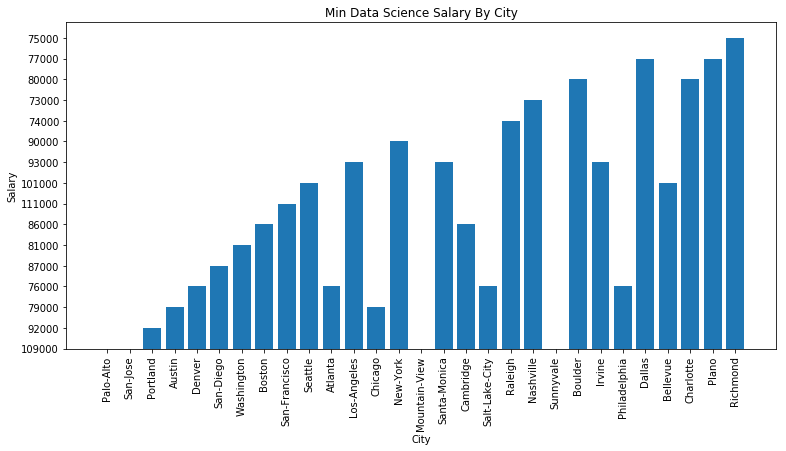

In [32]:
x = glassdoor_salaries.index
y = glassdoor_salaries['min_salary']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Salary')
ax.set_title("Min Data Science Salary By City")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

# Income Taxes

In [14]:
income_taxes_dct = {
    'Palo-Alto' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'San-Jose' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Portland' : {'rate': .0900 , 'standard_deduction' : 2175 ,
                   'personal_exemption' : 90},
    
    'Austin' : {'rate': 0, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Denver' : {'rate': .0463, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'San-Diego' : {'rate': .0930, 'standard_deduction' : 12000,
                   'personal_exemption' : 0},
    
    'Washington' : {'rate': .0850, 'standard_deduction' : 0,
                   'personal_exemption' : 2000},
    
    'Boston' : {'rate': .0510, 'standard_deduction' : 0,
                   'personal_exemption' : 4400},
    
    'San-Francisco' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Seattle' : {'rate': 0, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Atlanta' : {'rate': .06, 'standard_deduction' : 4600,
                   'personal_exemption' : 2700},
    
    'Los-Angeles' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 2000},
    
    'Chicago' : {'rate': .0495, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'New-York' : {'rate': .0657, 'standard_deduction' : 8000,
                   'personal_exemption' : 0},
    
    'Mountain-View' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Santa-Monica' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Cambridge' : {'rate': .0510, 'standard_deduction' : 0,
                   'personal_exemption' : 4400},
    
    'Salt-Lake-City' : {'rate': .050, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Raleigh' : {'rate': .05499, 'standard_deduction' : 8750,
                   'personal_exemption' :0},
    
    'Nashville' : {'rate': .03, 'standard_deduction' : 0,
                   'personal_exemption' : 1250},
    
    'Sunnyvale' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Boulder' : {'rate': .0463, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Irvine' : {'rate': .0930, 'standard_deduction' : 4236,
                   'personal_exemption' : 114},
    
    'Philadelphia' : {'rate': .0307, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Dallas' : {'rate': 0, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Bellevue' : {'rate': 0, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Charlotte' : {'rate': .05499, 'standard_deduction' : 8750,
                   'personal_exemption' :0},
    
    'Plano' : {'rate': 0, 'standard_deduction' : 0,
                   'personal_exemption' : 0},
    
    'Richmond' : {'rate': .0575, 'standard_deduction' : 3000,
                   'personal_exemption' : 930},    
}


In [30]:
income_taxes_dct = pd.DataFrame(income_taxes_dct).T

# Combine Income Tax Information With Salaries

In [35]:
#glassdoor_salaries.set_index('city', inplace=True)
dfs2 = [glassdoor_salaries, income_taxes_dct]
city_incomes_taxes = pd.concat(dfs2, axis=1)

## Cast min and max salary columns to float so that math can be performed on them

In [36]:
city_incomes_taxes.min_salary = city_incomes_taxes.min_salary.astype(float)
city_incomes_taxes.avg_salary = city_incomes_taxes.avg_salary.astype(float)

## Calculate adjusted min/average salary for each city

In [37]:
city_incomes_taxes['Adjusted_Min_Salary'] = (
    city_incomes_taxes['min_salary'] - 
    (city_incomes_taxes['min_salary'] * city_incomes_taxes['rate']) - 
    city_incomes_taxes['personal_exemption'] - city_incomes_taxes['standard_deduction'])

In [38]:
city_incomes_taxes['Adjusted_Avg_Salary'] = (
    city_incomes_taxes['avg_salary'] - 
    (city_incomes_taxes['avg_salary'] * city_incomes_taxes['rate']) - 
    city_incomes_taxes['personal_exemption'] - city_incomes_taxes['standard_deduction'])

## Sort index so that we can easily concatenate this DataFrame with our Cost-Of-Living DataFrame

In [39]:
city_incomes_taxes.sort_index(inplace=True)

## Estimate Net Monthly Income For Each Living Situation

In [40]:
dfs3 = [city_incomes_taxes, city_matrix.drop(columns='city').sort_index()]
net_monthly = pd.concat(dfs3, axis=1)
net_monthly

,city,min_salary,avg_salary,personal_exemption,rate,standard_deduction,Adjusted_Min_Salary,Adjusted_Avg_Salary,1_Bed_Center_Total,3_Bed_Center_Total,1_Bed_Outside_Total,3_Bed_Outside_Total
city,,,,,,,,,,,,
Atlanta,atlanta,76000.0,99680.0,2700.0,0.06000,4600.0,64140.00,86399.20000,2827.69,2214.31,2370.73,1881.12
Austin,austin,79000.0,103313.0,0.0,0.00000,0.0,79000.00,103313.00000,2969.98,2289.77,2399.66,1943.74
Bellevue,bellevue,101000.0,131112.0,0.0,0.00000,0.0,101000.00,131112.00000,3430.36,2473.14,3130.89,2220.37
Boston,boston,86000.0,112468.0,4400.0,0.05100,0.0,77214.00,102332.13200,3821.53,2853.37,3136.48,2316.50
Boulder,boulder,80000.0,104962.0,0.0,0.04630,0.0,76296.00,100102.25940,2824.38,2341.05,2562.76,2122.53
Cambridge,cambridge,86000.0,112468.0,4400.0,0.05100,0.0,77214.00,102332.13200,2314.90,1854.07,2086.22,1725.55
Charlotte,charlotte,80000.0,104647.0,0.0,0.05499,8750.0,66850.80,90142.46147,2717.21,2051.36,2269.79,1797.04
Chicago,chicago,79000.0,103685.0,0.0,0.04950,0.0,75089.50,98552.59250,3078.89,2405.30,2463.50,1993.23
Dallas,dallas,77000.0,101853.0,0.0,0.00000,0.0,77000.00,101853.00000,2589.88,2094.07,2254.14,1868.29


## Calculate the Net Monthly total for each of the 4 predetermined living scenarios

In [41]:
net_monthly['1BC_Net'] = round(((net_monthly['Adjusted_Min_Salary'] / 12) - net_monthly['1_Bed_Center_Total']),2)
net_monthly['1BO_Net'] = round(((net_monthly['Adjusted_Min_Salary'] / 12) - net_monthly['1_Bed_Outside_Total']),2)
net_monthly['3BC_Net'] = round(((net_monthly['Adjusted_Min_Salary'] / 12) - net_monthly['3_Bed_Center_Total']),2)
net_monthly['3BO_Net'] = round(((net_monthly['Adjusted_Min_Salary'] / 12) - net_monthly['3_Bed_Outside_Total']),2)

## Years To Pay Off Debt (Assuming Allocation Of 30% Net Per/Month)
#### Also, cut down df to only include columns that represent Years-To-Pay-Off-Debt

In [42]:
net_monthly_slim = net_monthly.iloc[:,-4:]

In [43]:
net_monthly_slim['1BC_Yrs'] = round(debt / ((net_monthly_slim['1BC_Net'] * .30) * 12),2)
net_monthly_slim['1BO_Yrs'] = round(debt / ((net_monthly_slim['1BO_Net'] * .30) * 12),2)
net_monthly_slim['3BC_Yrs'] = round(debt / ((net_monthly_slim['3BC_Net'] * .30) * 12),2)
net_monthly_slim['3BO_Yrs'] = round(debt / ((net_monthly_slim['3BO_Net'] * .30) * 12),2)

## Finally, graph our 4 different living scenarios in each of our chosen cities

<BarContainer object of 29 artists>

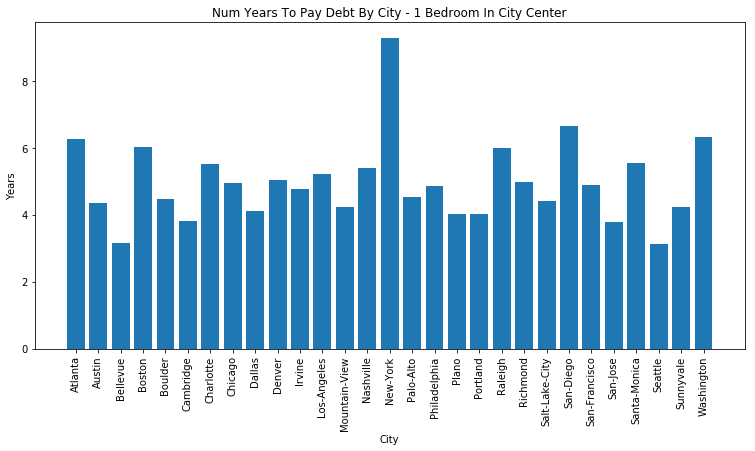

In [44]:
x = net_monthly_slim.index
y = net_monthly_slim['1BC_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 1 Bedroom In City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

<BarContainer object of 29 artists>

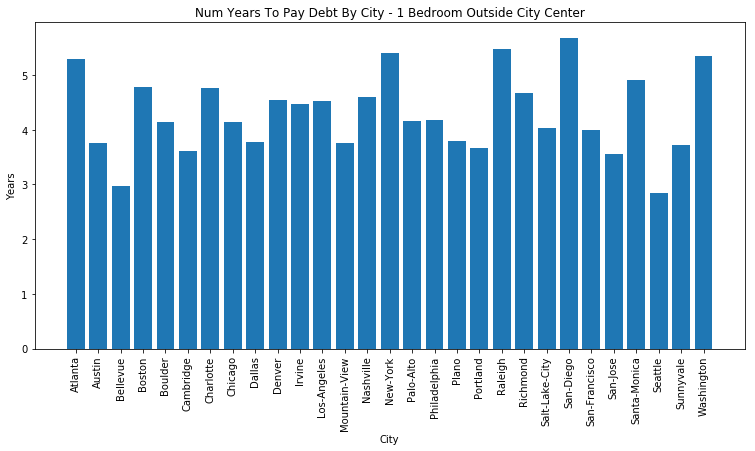

In [45]:
x = net_monthly_slim.index
y = net_monthly_slim['1BO_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 1 Bedroom Outside City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

<BarContainer object of 29 artists>

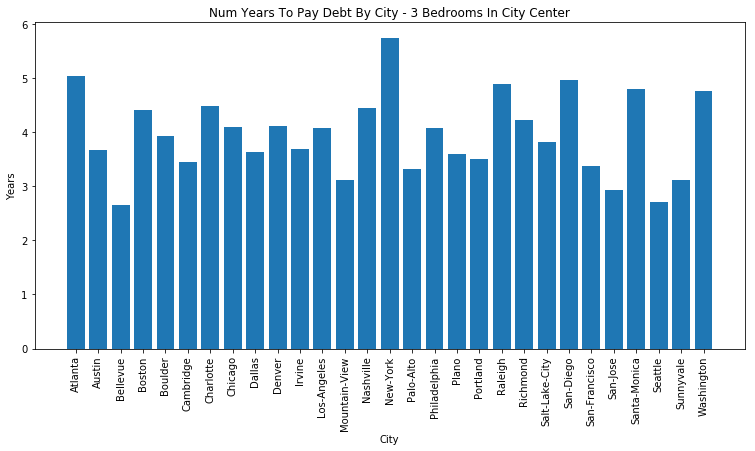

In [46]:
x = net_monthly_slim.index
y = net_monthly_slim['3BC_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 3 Bedrooms In City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

<BarContainer object of 29 artists>

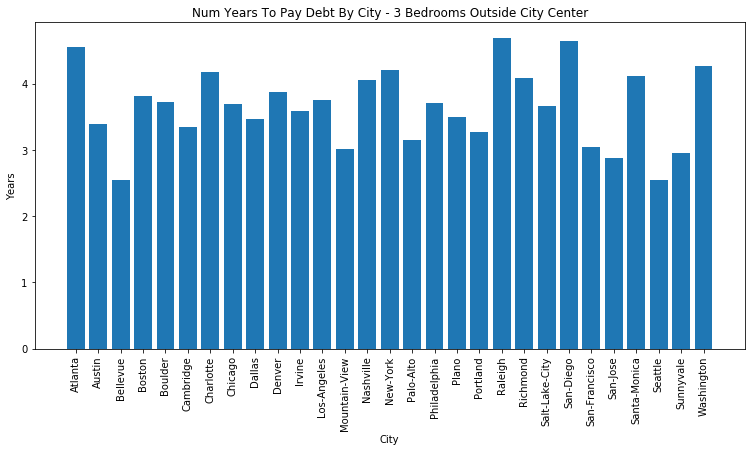

In [47]:
x = net_monthly_slim.index
y = net_monthly_slim['3BO_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 3 Bedrooms Outside City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

# Do everything again for Data Analyst Positions

In [3]:
df = pd.read_pickle('/Users/austin/Documents/Knowledge/LifeStyleDesign/city_matrix')

In [4]:
df

,1_Bed_Center_Total,3_Bed_Center_Total,1_Bed_Outside_Total,3_Bed_Outside_Total
city,,,,
Palo-Alto,4387.48,3127.55,4094.21,2871.99
San-Jose,3714.08,2500.71,3456.40,2415.23
Portland,2864.56,2296.22,2485.55,1980.12
Austin,2969.98,2289.77,2399.66,1943.74
Denver,2907.57,2211.63,2574.14,1982.24
San-Diego,3210.41,2406.10,2804.00,2184.68
Washington,3517.34,2701.31,3064.00,2314.06
Boston,3821.77,2853.61,3136.72,2316.74
San-Francisco,4806.91,3329.76,4053.38,2852.41


In [5]:
data_analyst_salaries_dct = {
    'palo-alto' : 'https://www.glassdoor.com/Salaries/san-jose-data-analyst-salary-SRCH_IL.0,8_IM761_KO9,21.htm',
    'san-jose' : 'https://www.glassdoor.com/Salaries/san-jose-data-analyst-salary-SRCH_IL.0,8_IM761_KO9,21.htm',
    'portland' : 'https://www.glassdoor.com/Salaries/portland-data-analyst-salary-SRCH_IL.0,8_IM700_KO9,21.htm',
    'austin' : 'https://www.glassdoor.com/Salaries/austin-data-analyst-salary-SRCH_IL.0,6_IM60_KO7,19.htm',
    'denver' : 'https://www.glassdoor.com/Salaries/denver-data-analyst-salary-SRCH_IL.0,6_IM234_KO7,19.htm',
    'san-diego' : 'https://www.glassdoor.com/Salaries/san-diego-data-analyst-salary-SRCH_IL.0,9_IM758_KO10,22.htm',
    'washington' : 'https://www.glassdoor.com/Salaries/washington-dc-data-analyst-salary-SRCH_IL.0,13_IM911_KO14,26.htm',
    'boston' : 'https://www.glassdoor.com/Salaries/boston-data-analyst-salary-SRCH_IL.0,6_IM109_KO7,19.htm',
    'san-francisco' : 'https://www.glassdoor.com/Salaries/san-francisco-data-analyst-salary-SRCH_IL.0,13_IM759_KO14,26.htm',
    'seattle' : 'https://www.glassdoor.com/Salaries/seattle-data-analyst-salary-SRCH_IL.0,7_IM781_KO8,20.htm',
    'atlanta' : 'https://www.glassdoor.com/Salaries/atlanta-data-analyst-salary-SRCH_IL.0,7_IM52_KO8,20.htm',
    'los-angeles' : 'https://www.glassdoor.com/Salaries/los-angeles-data-analyst-salary-SRCH_IL.0,11_IM508_KO12,24.htm',
    'chicago' : 'https://www.glassdoor.com/Salaries/chicago-data-analyst-salary-SRCH_IL.0,7_IM167_KO8,20.htm',
    'new-york' : 'https://www.glassdoor.com/Salaries/new-york-city-data-analyst-salary-SRCH_IL.0,13_IM615_KO14,26.htm',
    'mountain-view' : 'https://www.glassdoor.com/Salaries/san-jose-data-analyst-salary-SRCH_IL.0,8_IM761_KO9,21.htm',
    'santa-monica' : 'https://www.glassdoor.com/Salaries/los-angeles-data-analyst-salary-SRCH_IL.0,11_IM508_KO12,24.htm',
    'cambridge' : 'https://www.glassdoor.com/Salaries/boston-data-analyst-salary-SRCH_IL.0,6_IM109_KO7,19.htm',
    'salt-lake-city' : 'https://www.glassdoor.com/Salaries/salt-lake-city-data-analyst-salary-SRCH_IL.0,14_IM755_KO15,27.htm',
    'raleigh' : 'https://www.glassdoor.com/Salaries/raleigh-data-analyst-salary-SRCH_IL.0,7_IM714_KO8,20.htm',
    'nashville' : 'https://www.glassdoor.com/Salaries/nashville-data-analyst-salary-SRCH_IL.0,9_IM604_KO10,22.htm',
    'sunnyvale' : 'https://www.glassdoor.com/Salaries/san-jose-data-analyst-salary-SRCH_IL.0,8_IM761_KO9,21.htm',
    'boulder' : 'https://www.glassdoor.com/Salaries/boulder-data-analyst-salary-SRCH_IL.0,7_IM110_KO8,20.htm',
    'irvine' : 'https://www.glassdoor.com/Salaries/los-angeles-data-analyst-salary-SRCH_IL.0,11_IM508_KO12,24.htm',
    'philadelphia' : 'https://www.glassdoor.com/Salaries/philadelphia-data-analyst-salary-SRCH_IL.0,12_IM676_KO13,25.htm',
    'dallas' : 'https://www.glassdoor.com/Salaries/dallas-data-analyst-salary-SRCH_IL.0,6_IM218_KO7,19.htm',
    'bellevue' : 'https://www.glassdoor.com/Salaries/seattle-data-analyst-salary-SRCH_IL.0,7_IM781_KO8,20.htm',
    'charlotte' : 'https://www.glassdoor.com/Salaries/charlotte-data-analyst-salary-SRCH_IL.0,9_IM162_KO10,22.htm',
    'Plano' : 'https://www.glassdoor.com/Salaries/dallas-data-analyst-salary-SRCH_IL.0,6_IM218_KO7,19.htm',
    'Richmond' : 'https://www.glassdoor.com/Salaries/richmond-data-analyst-salary-SRCH_IL.0,8_IM724_KO9,21.htm',    
}


In [18]:
analyst_glassdoor_salaries = list(get_glassdoor_salaries(data_analyst_salaries_dct))
analyst_glassdoor_salaries = pd.DataFrame(analyst_glassdoor_salaries)

In [22]:
columns=["city", "min_salary", "avg_salary"]
analyst_glassdoor_salaries = analyst_glassdoor_salaries.reindex(columns=columns)

In [23]:
analyst_glassdoor_index = ['Palo-Alto', 'San-Jose', 'Portland', 'Austin', 'Denver', 'San-Diego',
       'Washington', 'Boston', 'San-Francisco', 'Seattle', 'Atlanta',
       'Los-Angeles', 'Chicago', 'New-York', 'Mountain-View', 'Santa-Monica',
       'Cambridge', 'Salt-Lake-City', 'Raleigh', 'Nashville', 'Sunnyvale',
       'Boulder', 'Irvine', 'Philadelphia', 'Dallas', 'Bellevue', 'Charlotte',
       'Plano', 'Richmond']
analyst_glassdoor_salaries.index = analyst_glassdoor_index

In [27]:
analyst_glassdoor_salaries.drop(columns='city', inplace=True)

In [28]:
##  Pickle DF ##
analyst_glassdoor_salaries.to_pickle('analyst_glassdoor_salaries')

In [37]:
dfs2 = [analyst_glassdoor_salaries, income_taxes_dct]
analyst_city_incomes_taxes = pd.concat(dfs2, axis=1)

In [39]:
analyst_city_incomes_taxes.min_salary = analyst_city_incomes_taxes.min_salary.astype(float)
analyst_city_incomes_taxes.avg_salary = analyst_city_incomes_taxes.avg_salary.astype(float)

In [41]:
analyst_city_incomes_taxes['Adjusted_Min_Salary'] = (
    analyst_city_incomes_taxes['min_salary'] - 
    (analyst_city_incomes_taxes['min_salary'] * analyst_city_incomes_taxes['rate']) - 
    analyst_city_incomes_taxes['personal_exemption'] - analyst_city_incomes_taxes['standard_deduction'])

In [42]:
analyst_city_incomes_taxes['Adjusted_Avg_Salary'] = (
    analyst_city_incomes_taxes['avg_salary'] - 
    (analyst_city_incomes_taxes['avg_salary'] * analyst_city_incomes_taxes['rate']) - 
    analyst_city_incomes_taxes['personal_exemption'] - analyst_city_incomes_taxes['standard_deduction'])

In [43]:
analyst_city_incomes_taxes.sort_index(inplace=True)

In [44]:
dfs3 = [analyst_city_incomes_taxes, df.sort_index()]
analyst_net_monthly = pd.concat(dfs3, axis=1)
analyst_net_monthly

,min_salary,avg_salary,personal_exemption,rate,standard_deduction,Adjusted_Min_Salary,Adjusted_Avg_Salary,1_Bed_Center_Total,3_Bed_Center_Total,1_Bed_Outside_Total,3_Bed_Outside_Total
city,,,,,,,,,,,
Atlanta,46000.0,63247.0,2700.0,0.06000,4600.0,35940.00,52152.18000,2826.20,2212.82,2369.24,1879.63
Austin,44000.0,60804.0,0.0,0.00000,0.0,44000.00,60804.00000,2969.98,2289.77,2399.66,1943.74
Bellevue,50000.0,68399.0,0.0,0.00000,0.0,50000.00,68399.00000,3430.36,2473.14,3130.89,2220.37
Boston,49000.0,67184.0,4400.0,0.05100,0.0,42101.00,59357.61600,3821.77,2853.61,3136.72,2316.74
Boulder,36000.0,49746.0,0.0,0.04630,0.0,34333.20,47442.76020,2824.38,2341.05,2562.76,2122.53
Cambridge,49000.0,67184.0,4400.0,0.05100,0.0,42101.00,59357.61600,2314.90,1854.07,2086.22,1725.55
Charlotte,46000.0,63528.0,0.0,0.05499,8750.0,34720.46,51284.59528,2717.21,2051.36,2269.79,1797.04
Chicago,46000.0,63218.0,0.0,0.04950,0.0,43723.00,60088.70900,3078.89,2405.30,2463.50,1993.23
Dallas,48000.0,66387.0,0.0,0.00000,0.0,48000.00,66387.00000,2590.93,2092.87,2255.06,1867.09


In [45]:
analyst_net_monthly['1BC_Net'] = round(((analyst_net_monthly['Adjusted_Avg_Salary'] / 12) - analyst_net_monthly['1_Bed_Center_Total']),2)
analyst_net_monthly['1BO_Net'] = round(((analyst_net_monthly['Adjusted_Avg_Salary'] / 12) - analyst_net_monthly['1_Bed_Outside_Total']),2)
analyst_net_monthly['3BC_Net'] = round(((analyst_net_monthly['Adjusted_Avg_Salary'] / 12) - analyst_net_monthly['3_Bed_Center_Total']),2)
analyst_net_monthly['3BO_Net'] = round(((analyst_net_monthly['Adjusted_Avg_Salary'] / 12) - analyst_net_monthly['3_Bed_Outside_Total']),2)

In [46]:
analyst_net_monthly_slim = analyst_net_monthly.iloc[:,-4:]

In [47]:
analyst_net_monthly_slim['1BC_Yrs'] = round(debt / ((analyst_net_monthly_slim['1BC_Net'] * .30) * 12),2)
analyst_net_monthly_slim['1BO_Yrs'] = round(debt / ((analyst_net_monthly_slim['1BO_Net'] * .30) * 12),2)
analyst_net_monthly_slim['3BC_Yrs'] = round(debt / ((analyst_net_monthly_slim['3BC_Net'] * .30) * 12),2)
analyst_net_monthly_slim['3BO_Yrs'] = round(debt / ((analyst_net_monthly_slim['3BO_Net'] * .30) * 12),2)

<BarContainer object of 29 artists>

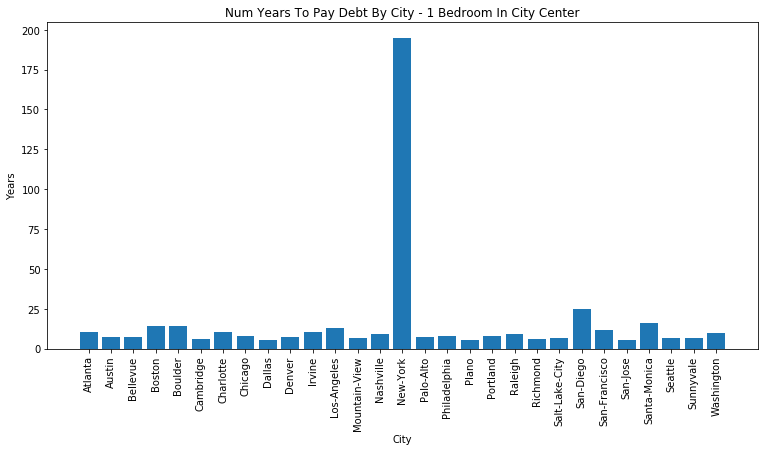

In [48]:
x = analyst_net_monthly_slim.index
y = analyst_net_monthly_slim['1BC_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 1 Bedroom In City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

In [49]:
analyst_net_monthly_slim

,1BC_Net,1BO_Net,3BC_Net,3BO_Net,1BC_Yrs,1BO_Yrs,3BC_Yrs,3BO_Yrs
city,,,,,,,,
Atlanta,1519.82,1976.78,2133.20,2466.39,10.36,7.97,7.38,6.39
Austin,2097.02,2667.34,2777.23,3123.26,7.51,5.90,5.67,5.04
Bellevue,2269.56,2569.03,3226.78,3479.55,6.94,6.13,4.88,4.53
Boston,1124.70,1809.75,2092.86,2629.73,14.00,8.70,7.53,5.99
Boulder,1129.18,1390.80,1612.51,1831.03,13.95,11.32,9.77,8.60
Cambridge,2631.57,2860.25,3092.40,3220.92,5.99,5.51,5.09,4.89
Charlotte,1556.51,2003.93,2222.36,2476.68,10.12,7.86,7.09,6.36
Chicago,1928.50,2543.89,2602.09,3014.16,8.17,6.19,6.05,5.23
Dallas,2941.32,3277.19,3439.38,3665.16,5.35,4.81,4.58,4.30


<BarContainer object of 29 artists>

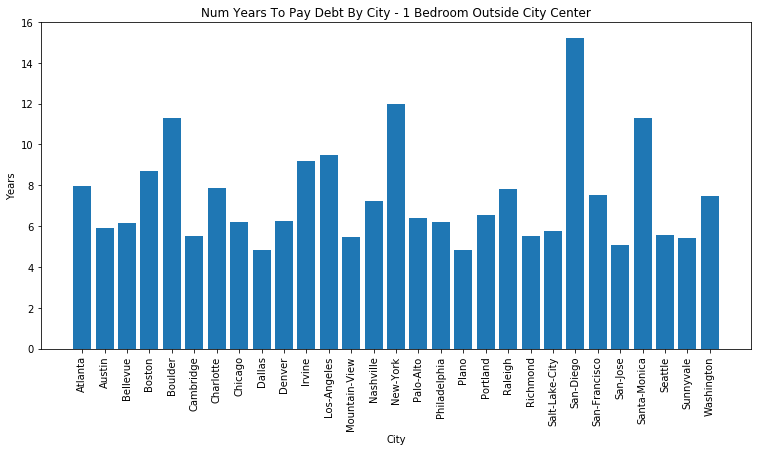

In [50]:
x = analyst_net_monthly_slim.index
y = analyst_net_monthly_slim['1BO_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 1 Bedroom Outside City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

<BarContainer object of 29 artists>

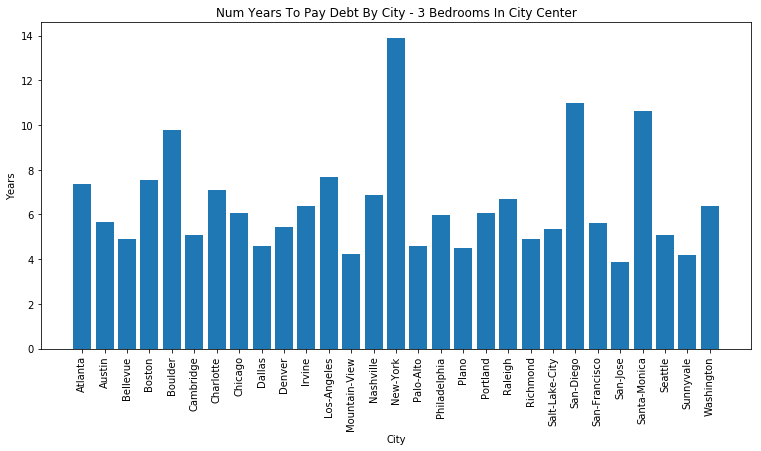

In [51]:
x = analyst_net_monthly_slim.index
y = analyst_net_monthly_slim['3BC_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 3 Bedrooms In City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)

<BarContainer object of 29 artists>

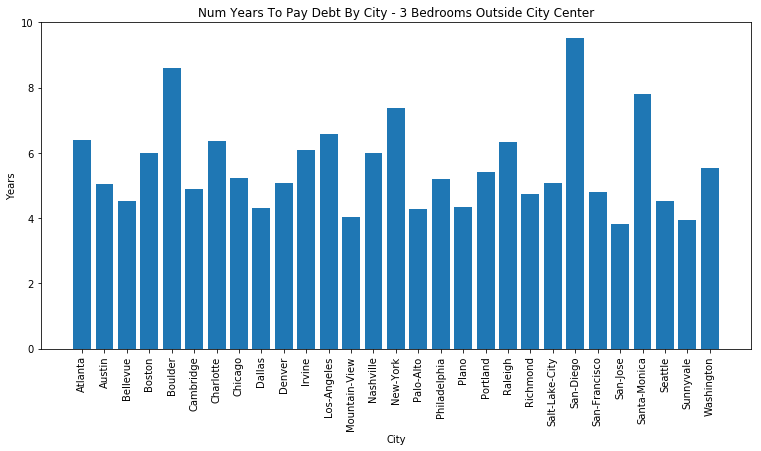

In [52]:
x = analyst_net_monthly_slim.index
y = analyst_net_monthly_slim['3BO_Yrs']

fig = plt.figure(figsize=(28,6))
ax = fig.add_subplot(121)
ax.set_xlabel('City')
ax.set_ylabel('Years')
ax.set_title("Num Years To Pay Debt By City - 3 Bedrooms Outside City Center")
ax.set_xticklabels(x, rotation=90)
ax.bar(x,y)